# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded .zip files
- Perform exploratory data analysis (EDA)
- Establish a baseline model
- Move from a simple model to an ensemble model
- Perform hyperparameter optimization
- Check feature importance


## Introduction to business scenario

You work for a travel booking website that wants to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed because of weather when they book a flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by using machine learning (ML) to identify whether the flight will be delayed because of weather. You have been given access to the a dataset about the on-time performance of domestic flights that were operated by large air carriers. You can use this data to train an ML model to predict if the flight is going to be delayed for the busiest airports.


## About this dataset

This dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the U.S. Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2013 and 2018.


### Features

For more information about features in the dataset, see [On-time delay dataset features](https://www.transtats.bts.gov/Fields.asp).

### Dataset attributions  
Website: https://www.transtats.bts.gov/

Dataset(s) used in this lab were compiled by the U.S. Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available at https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&DB_URL=Mode_ID=1&Mode_Desc=Aviation&Subject_ID2=0.

# Step 1: Problem formulation and data collection

Start this project by writing a few sentences that summarize the business problem and the business goal that you want to achieve in this scenario. You can write down your ideas in the following sections. Include a business metric that you would like your team to aspire toward. After you define that information, write the ML problem statement. Finally, add a comment or two about the type of ML this activity represents. 

#### <span style="color: blue;">Project presentation: Include a summary of these details in your project presentation.</span>

### 1. Determine if and why ML is an appropriate solution to deploy for this scenario.

Yes ML would be an appropriate solution here due to various factors
* Volume of data: Since we have large volume of data that exists, it helps ML model to learn from it and predict the output better.
* Nature of the dataset: Since flight delays, especially those caused by weather, are influenced by multiple factors such as departure time, origin, destination, distance, seasonality, and airline. Traditional statistical rule based models might not be able to identify the hidden patterns.
* Continuous Improvement: As more data is collected, the ML model can be retrained and fine-tuned to improve its predictions, adapting to changing flight patterns and weather conditions.


### 2. Formulate the business problem, success metrics, and desired ML output.

Flight delays can cause significant discomfort to the travelers and also damage the reputation of the air carrier agency. Our goal is to improve customer experience by predicting weather-related delays at the busiest US airports and notifying customers at the time of booking. This would allow the travellers to plan their iternary, take informed decision, and avoiding any inconvenience that could be caused due to the delay.

### 3. Identify the type of ML problem that you're working with.

* ROC-AUC (Area under the ROC curve): Measures the model’s ability to distinguish between delayed and non-delayed flights. Larger the area under the curve, better is the model.
* Accuracy : Overall proportion of correct predictions.
* Precision : Ensures that when a delay is predicted, it’s likely to be accurate.
* Sensitivity : Ensures that most actual delays are identified.
* Specificity : Correctly identifies non-delayed flights.
* False Positive Rate : Percentage of non-delayed flights incorrectly predicted as delayed.
* False Negative Rate : Percentage of missed delays.# Write your answer here

### 4. Analyze the appropriateness of the data that you're working with.

Binary Classification:
1: Flight delayed due to weather
0: No delay or delay not caused by weather

### Setup

Now that you have decided where you want to focus your attention, you will set up this lab so that you can start solving the problem.

**Note:** This notebook was created and tested on an `ml.m4.xlarge` notebook instance with 25 GB storage. 

In [1]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
instance_type='ml.m4.xlarge'

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a pandas DataFrame. After you import the data, explore the dataset. Look for the shape of the dataset and explore your columns and the types of columns that you will work with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Examine your target column closely, and determine its distribution.


### Specific questions to consider

Throughout this section of the lab, consider the following questions:

1. What can you deduce from the basic statistics that you ran on the features? 
2. What can you deduce from the distributions of the target classes?
3. Is there anything else you can deduce by exploring the data?

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these questions (and other similar questions) in your project presentation.</span>

Start by bringing in the dataset from a public Amazon Simple Storage Service (Amazon S3) bucket to this notebook environment.

In [2]:
# download the files

zip_path = '/home/ec2-user/SageMaker/project/data/FlightDelays/'
base_path = '/home/ec2-user/SageMaker/project/data/FlightDelays/'
csv_base_path = '/home/ec2-user/SageMaker/project/data/csvFlightDelays/'

!mkdir -p {zip_path}
!mkdir -p {csv_base_path}
!aws s3 cp s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/ {zip_path} --recursive


download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip
download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip
download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_prese

In [3]:
zip_files = [str(file) for file in list(Path(base_path).iterdir()) if '.zip' in str(file)]
len(zip_files)

60

Extract comma-separated values (CSV) files from the .zip files.

In [4]:
def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

for file in zip_files:
    zip2csv(file, csv_base_path)

print("Files Extracted")

Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_4.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_3.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_7.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_6.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_1.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_4.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_10.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Tim

In [5]:
csv_files = [str(file) for file in list(Path(csv_base_path).iterdir()) if '.csv' in str(file)]
len(csv_files)

60

Before you load the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information about the features that are included in the dataset.

In [6]:
from IPython.display import IFrame

IFrame(src=os.path.relpath(f"{csv_base_path}readme.html"), width=1000, height=600)

#### Load sample CSV file

Before you combine all the CSV files, examine the data from a single CSV file. By using pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the built-in `read_csv` function in Python ([pandas.read_csv documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [7]:
df_temp = pd.read_csv(f"{csv_base_path}On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv")

**Question**: Print the row and column length in the dataset, and print the column names.

**Hint**: To view the rows and columns of a DataFrame, use the `<DataFrame>.shape` function. To view the column names, use the `<DataFrame>.columns` function.

In [8]:
df_shape = df_temp.shape
print(f'Rows and columns in one CSV file is {df_shape}')

Rows and columns in one CSV file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

**Hint**: To print `x` number of rows, use the built-in `head(x)` function in pandas.

In [9]:
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. To view the column names, use `<DataFrame>.columns`.

In [11]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word *Del*. This will help you see how many columns have *delay data* in them.

**Hint**: To include values that pass certain `if` statement criteria, you can use a Python list comprehension.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: To check if the value is in a list, you can use the `in` keyword ([Python in Keyword documentation](https://www.w3schools.com/python/ref_keyword_in.asp)). 

For example: `5 in [1,2,3,4,5]`

In [12]:
print([x for x in df_temp.columns if "Del" in x])

['DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'DivArrDelay']


Here are some more questions to help you learn more about your dataset.

**Questions**   

1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

**Hints**
- To show the dimensions of the DataFrame, use `df_temp.shape`.
- To refer to a specific column, use `df_temp.columnName` (for example, `df_temp.CarrierDelay`).
- To get unique values for a column, use `df_temp.column.unique()` (for, example `df_temp.Year.unique()`).

In [24]:
print("The #rows and #columns are ", df_temp.shape[0] , " and ", df_temp.shape[1])
print("The years in this dataset are: ", df_temp.Year.unique())
print("The months covered in this dataset are: ", df_temp.Month.unique())
print("The date range for data is :" , min(df_temp.FlightDate.unique()), " to ", max(df_temp.FlightDate.unique()))
print("The airlines covered in this dataset are: ", list(df_temp.Reporting_Airline.unique()))
print("The Origin airports covered are: ", list(df_temp.Origin.unique()))
print("The Destination airports covered are: ", list(df_temp.Dest.unique()))

The #rows and #columns are  585749  and  110
The years in this dataset are:  [2018]
The months covered in this dataset are:  [9]
The date range for data is : 2018-09-01  to  2018-09-30
The airlines covered in this dataset are:  ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are:  ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ

**Question**: What is the count of all the origin and destination airports?

**Hint**: To find the values for each airport by using the **Origin** and **Dest** columns, you can use the `values_count` function in pandas ([pandas.Series.value_counts documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)).

In [15]:
counts = pd.DataFrame({'Origin':df_temp.Origin.value_counts(), 'Destination':df_temp.Dest.value_counts()})
counts

,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
...,...,...
WRG,60,60
WYS,52,52
XNA,1004,1004
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the `sort_values` function in pandas ([pandas.DataFrame.sort_values documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [16]:
counts.sort_values(by=['Origin', 'Destination'],ascending=False).head(15)

,Origin,Destination
ATL,31525,31521
ORD,28257,28250
DFW,22802,22795
DEN,19807,19807
CLT,19655,19654
LAX,17875,17873
SFO,14332,14348
IAH,14210,14203
LGA,13850,13850
MSP,13349,13347


**Given all the information about a flight trip, can you predict if it would be delayed?**

The **ArrDel15** column is an indicator variable that takes the value *1* when the delay is more than 15 minutes. Otherwise, it takes a value of *0*.

You could use this as a target column for the classification problem.

Now, assume that you are traveling from San Francisco to Los Angeles on a work trip. You want to better manage your reservations in Los Angeles. Thus, want to have an idea of whether your flight will be delayed, given a set of features. How many features from this dataset would you need to know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or the destination. If there were a sudden weather delay 10 minutes before landing, this data wouldn't be helpful to managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top five airlines: UA, OO, WN, AA, DL

This information should help reduce the size of data across the CSV files that will be combined.

#### Combine all CSV files
 
First, create an empy DataFrame that you will use to copy your individual DataFrames from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe 
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the `subset_vals` in each of the `subset_cols`. To check if the `val` is in the DataFrame column, use the `isin` function in pandas ([pandas.DataFram.isin documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)). Then, choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the DataFrame with the empty DataFrame 

In [17]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):

    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """

    df = pd.DataFrame()
    
    for file in csv_files:
        df_temp = pd.read_csv(file)
        df_temp = df_temp[filter_cols]
        for col, val in zip(subset_cols,subset_vals):
            df_temp = df_temp[df_temp[col].isin(val)]      
        
        df = pd.concat([df, df_temp], axis=0)
      
    df.to_csv(file_name, index=False)
    print(f'Combined csv stored at {file_name}')

In [18]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the previous function to merge all the different files into a single file that you can read easily. 

**Note**: This process will take 5-7 minutes to complete.

In [19]:
start = time.time()
combined_csv_filename = f"{base_path}combined_files.csv"
combine_csv(csv_files, cols, subset_cols, subset_vals, combined_csv_filename)
print(f'CSVs merged in {round((time.time() - start)/60,2)} minutes')

Combined csv stored at /home/ec2-user/SageMaker/project/data/FlightDelays/combined_files.csv
CSVs merged in 4.74 minutes


#### Load the dataset

Load the combined dataset.

In [20]:
data = pd.read_csv(combined_csv_filename)

Print the first five records.

In [21]:
data.head(5)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2014,3,9,10,3,2014-09-10,UA,DEN,CO,ORD,IL,1050,0.0,0.0,888.0,4,-6.0,0.0,0.0,109.0
1,2014,3,9,10,3,2014-09-10,UA,IAH,TX,LAX,CA,715,0.0,0.0,1379.0,6,-27.0,0.0,0.0,173.0
2,2014,3,9,10,3,2014-09-10,UA,DEN,CO,LAX,CA,833,0.0,0.0,862.0,4,14.0,14.0,0.0,119.0
3,2014,3,9,10,3,2014-09-10,UA,DFW,TX,DEN,CO,604,0.0,0.0,641.0,3,-17.0,0.0,0.0,92.0
4,2014,3,9,10,3,2014-09-10,UA,ORD,IL,DEN,CO,1555,0.0,0.0,888.0,4,-12.0,0.0,0.0,122.0


Here are some more questions to help you learn more about your dataset.

**Questions**   

1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [23]:
print("The #rows and #columns are ", data.shape[0] , " and ", data.shape[1])
print("The years in this dataset are: ", data.Year.unique())
print("The months covered in this dataset are: ", sorted(list(data.Month.unique())))
print("The date range for data is :" , min(data.FlightDate.unique()), " to ", max(data.FlightDate.unique()))
print("The airlines covered in this dataset are: ", list(data.Reporting_Airline.unique()))
print("The Origin airports covered are: ", list(data.Origin.unique()))
print("The Destination airports covered are: ", list(data.Dest.unique()))

The #rows and #columns are  1658130  and  1658130
The years in this dataset are:  [2014 2016 2017 2018 2015]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is : 2014-01-01  to  2018-12-31
The airlines covered in this dataset are:  ['UA', 'OO', 'WN', 'AA', 'DL']
The Origin airports covered are:  ['DEN', 'IAH', 'DFW', 'ORD', 'LAX', 'SFO', 'ATL', 'PHX', 'CLT']
The Destination airports covered are:  ['ORD', 'LAX', 'DEN', 'SFO', 'IAH', 'DFW', 'PHX', 'ATL', 'CLT']


Define your target column: **is_delay** (*1* means that the arrival time delayed more than 15 minutes, and *0* means all other cases). To rename the column from **ArrDel15** to *is_delay*, use the `rename` method .

**Hint**: You can use the `rename` function in pandas ([pandas.DataFrame.rename documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
data.rename(columns={'col1':'column1'}, inplace=True)
```

In [25]:
data.rename(columns={'ArrDel15':'is_delay'}, inplace=True)

Look for nulls across columns. You can use the `isnull()` function ([pandas.isnull documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not. It returns a boolean (*True* or *False*) in its place. To sum the number of columns, use the `sum(axis=0)` function (for example, `df.isnull().sum(axis=0)`).

In [26]:
data.isnull().sum(axis=0)

Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64

The arrival delay details and airtime are missing for 22,540 out of 1,658,130 rows, which is 1.3 percent. You can either remove or impute these rows. The documentation doesn't mention any information about missing rows.


In [27]:
### Remove null columns
data = data[~data.is_delay.isnull()]
data.isnull().sum(axis = 0)

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
AirTime              0
dtype: int64

Get the hour of the day in 24-hour-time format from CRSDepTime.

In [28]:
data['DepHourofDay'] = (data['CRSDepTime']//100)

In [30]:
data['DepHourofDay'].head(5)

0    10
1     7
2     8
3     6
4    15
Name: DepHourofDay, dtype: int64

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only a value of *0* or *1*, you could use a classification algorithm. 

Before you start modeling, it's a good practice to look at feature distribution, correlations, and others.
- This will give you an idea of any non-linearity or patterns in the data
    - Linear models: Add power, exponential, or interaction features
    - Try a non-linear model
- Data imbalance 
    - Choose metrics that won't give biased model performance (accuracy versus the area under the curve, or AUC)
    - Use weighted or custom loss functions
- Missing data
    - Do imputation based on simple statistics -- mean, median, mode (numerical variables), frequent class (categorical variables)
    - Clustering-based imputation (k-nearest neighbors, or KNNs, to predict column value)
    - Drop column

### Data exploration

Check the classes *delay* versus *no delay*.


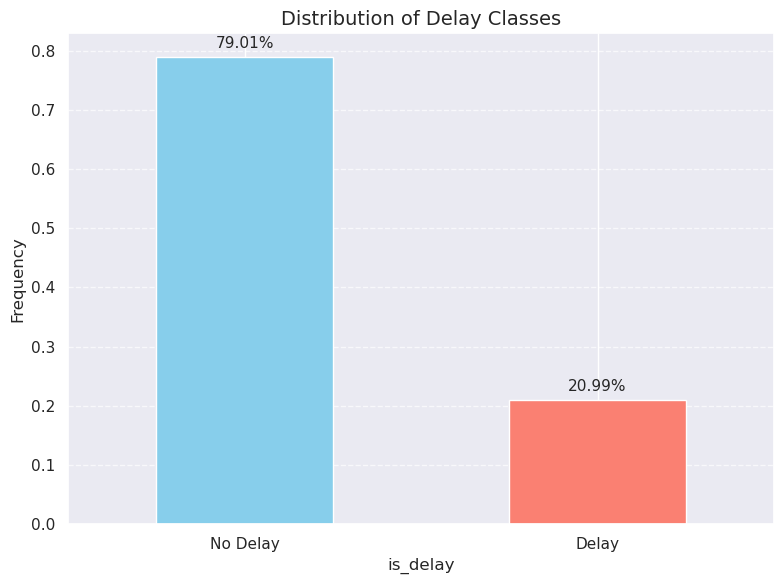

In [34]:
class_dist = (data.groupby('is_delay').size() / len(data))
ax = class_dist.plot(kind='bar', color=['skyblue', 'salmon'], figsize=(8, 6))

plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Delay Classes', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['No Delay', 'Delay'], rotation=0, fontsize=11)

for i, v in enumerate(class_dist):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of *delay* versus *no delay*?

20% of the the times the flights are delayed.

Run the following two cells and answer the questions.

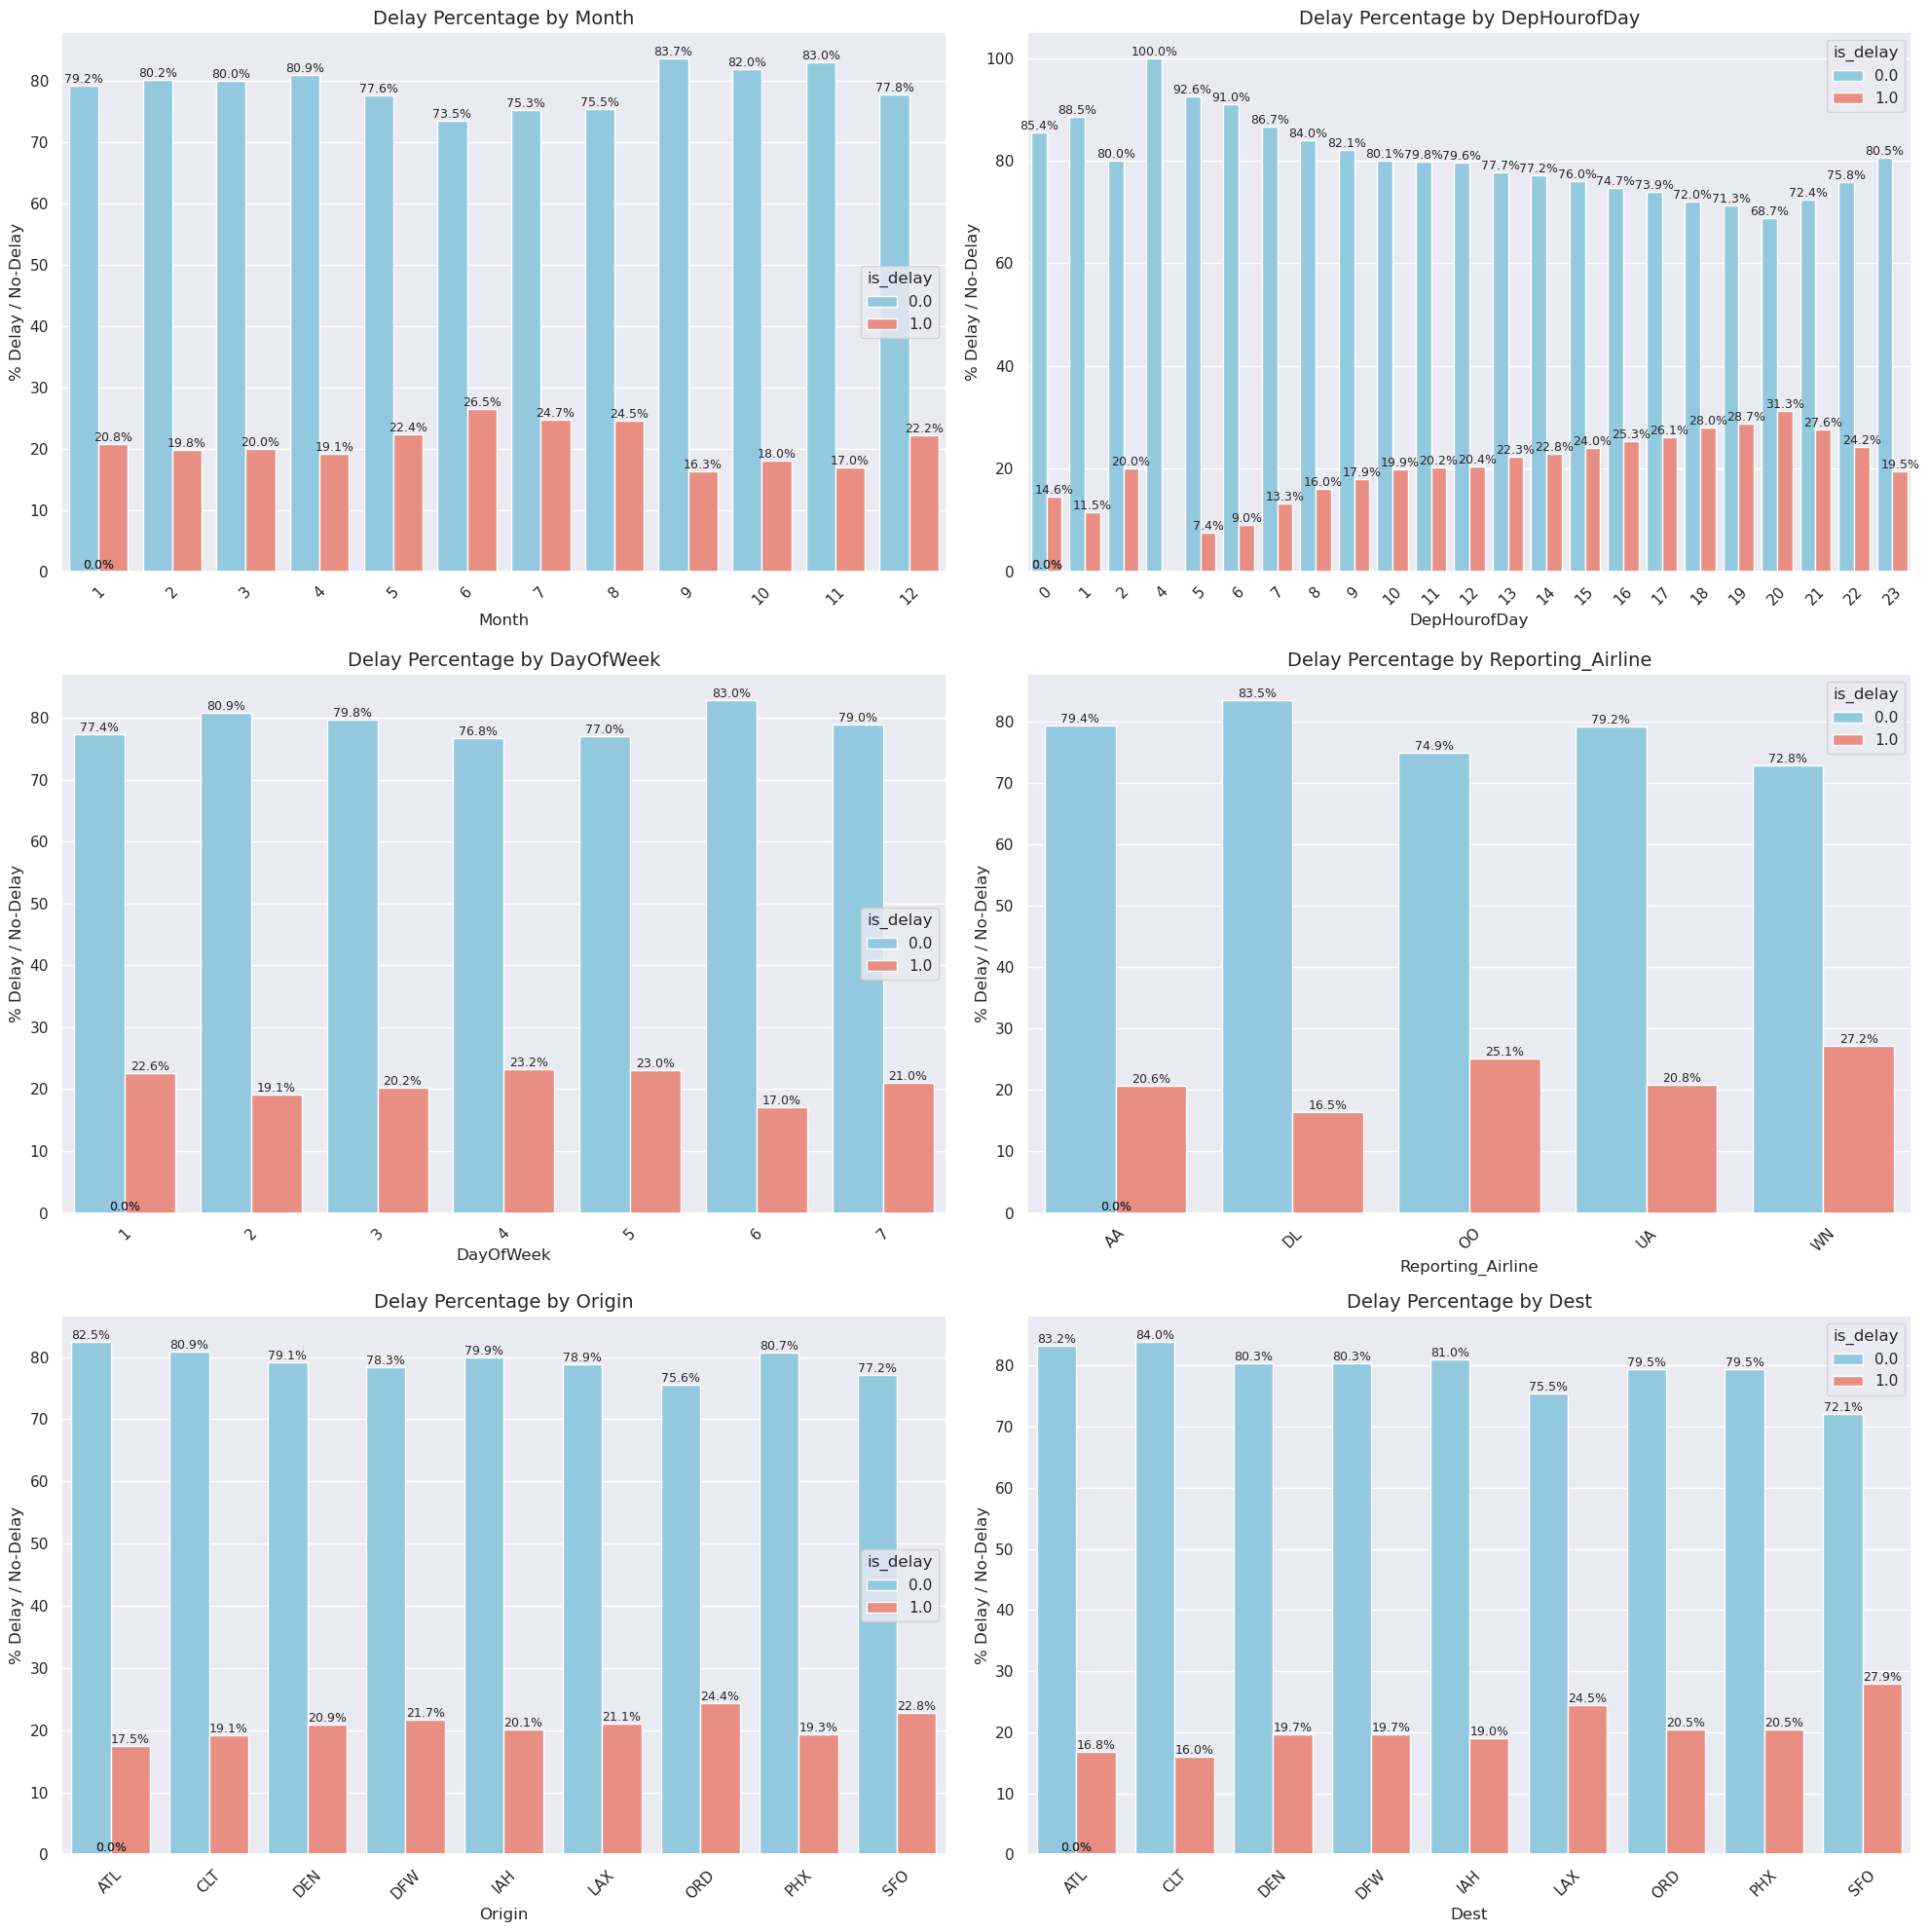

In [33]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20, 20), squeeze=False)

for idx, column in enumerate(viz_columns):
    ax = axes[idx // 2, idx % 2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage')\
              .mul(100).reset_index().sort_values(column)
    
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax,
                palette={0: 'skyblue', 1: 'salmon'})
    
    ax.set_title(f'Delay Percentage by {column}', fontsize=14)
    ax.set_ylabel('% Delay / No-Delay', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    
    # Annotate bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


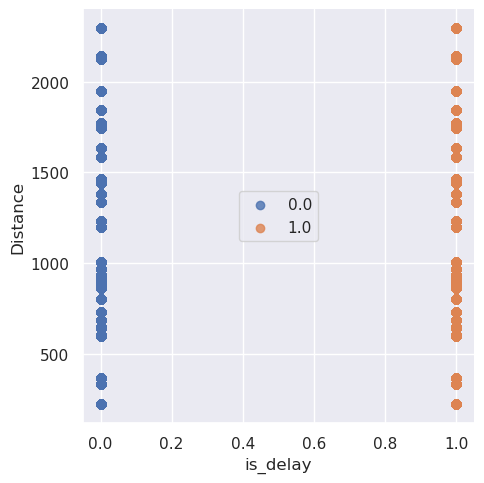

In [35]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

**Questions**

Using the data from the previous charts, answer these questions:

- Which months have the most delays?
- What time of the day has the most delays?
- What day of the week has the most delays?
- Which airline has the most delays?
- Which origin and destination airports have the most delays?
- Is flight distance a factor in the delays?

1. Most delays month: June
2. Time of the day : 20:00
3. Day of the week : 6
4. Airline with most delays : WN
5. Orign airport: ORD, Destination airport : SFO
6. Yes

### Features

Look at all the columns and what their specific types are.

In [36]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [37]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int64
dtype: object

Filtering the required columns:
- *Date* is redundant, because you have *Year*, *Quarter*, *Month*, *DayofMonth*, and *DayOfWeek* to describe the date.
- Use *Origin* and *Dest* codes instead of *OriginState* and *DestState*.
- Because you are only classifying whether the flight is delayed or not, you don't need *TotalDelayMinutes*, *DepDelayMinutes*, and *ArrDelayMinutes*.

Treat *DepHourofDay* as a categorical variable because it doesn't have any quantitative relation with the target.
- If you needed to do a one-hot encoding of this variable, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- In this case, you only need to split into buckets.

To change a column type to category, use the `astype` function ([pandas.DataFrame.astype documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [38]:
data_orig = data.copy()
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('category')

To use one-hot encoding, use the `get_dummies` function in pandas for the categorical columns that you selected. Then, you can concatenate those generated features to your original dataset by using the `concat` function in pandas. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information about dummy encoding, see [Dummy variable (statistics)](https://en.wikiversity.org/wiki/Dummy_variable_(statistics)).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [39]:
data_dummies = pd.get_dummies(data[['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']], drop_first=True) # Enter your code here
data_dummies = data_dummies.replace({True: 1, False: 0})
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

Check the length of the dataset and the new columns.

**Hint**: Use the `shape` and `columns` properties.

In [40]:
data.head(5)

,is_delay,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,0.0,888.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1379.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,862.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,641.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,888.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [43]:
print("Shape is:", data.shape)
print("Columns are:", data.columns)

Shape is: (1635590, 94)
Columns are: Index(['is_delay', 'Distance', 'Quarter_2', 'Quarter_3', 'Quarter_4',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Air

You are now ready to train the model. Before you split the data, rename the **is_delay** column to *target*.

**Hint**: You can use the `rename` function in pandas ([pandas.DataFrame.rename documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [44]:
data.rename(columns = {'is_delay':'target'}, inplace=True )# Enter your code here

In [45]:
data.head(5)

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,0.0,888.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1379.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,862.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,641.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,888.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## <span style="color:red"> End of Step 2 </span>

Save the project file to your local computer. Follow these steps:

1. In the file explorer on the left, right-click the notebook that you're working on. 

2. Choose **Download**, and save the file locally.  

This action downloads the current notebook to the default download folder on your computer.

# Step 3: Model training and evaluation

You must include some preliminary steps when you convert the dataset from a DataFrame to a format that a machine learning algorithm can use. For Amazon SageMaker, you must perform these steps:

1. Split the data into `train_data`, `validation_data`, and `test_data` by using `sklearn.model_selection.train_test_split`.  

2. Convert the dataset to an appropriate file format that the Amazon SageMaker training job can use. This can be either a CSV file or record protobuf. For more information, see [Common Data Formats for Training](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html).  

3. Upload the data to your S3 bucket. If you haven't created one before, see [Create a Bucket](https://docs.aws.amazon.com/AmazonS3/latest/gsg/CreatingABucket.html).  

Use the following cells to complete these steps. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: In your project presentation, write down the key decisions that you made in this phase.</span>

### Train-test split

In [46]:
from sklearn.model_selection import train_test_split
def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.2, random_state=42, stratify=data['target'])
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])
    return train, validate, test

In [47]:
train, validate, test = split_data(data)
print(train['target'].value_counts())
print(test['target'].value_counts())
print(validate['target'].value_counts())

0.0    1033806
1.0     274666
Name: target, dtype: int64
0.0    129226
1.0     34333
Name: target, dtype: int64
0.0    129226
1.0     34333
Name: target, dtype: int64


**Sample answer**
```
0.0    1033570
1.0     274902
Name: target, dtype: int64
0.0    129076
1.0     34483
Name: target, dtype: int64
0.0    129612
1.0     33947
Name: target, dtype: int64
```

### Baseline classification model

In [48]:
import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# Instantiate the LinearLearner estimator object with 1 ml.m4.xlarge
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                               binary_classifier_model_selection_criteria='cross_entropy_loss')

[04/06/25 03:41:38] INFO     Found credentials from IAM Role:                                   ]8;id=670075;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=176361;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[04/06/25 03:41:40] INFO     Found credentials from IAM Role:                                   ]8;id=364359;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=560892;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=84305;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=444880;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=402229;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=707684;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[04/06/25 03:41:41] INFO     Created S3 bucket: sagemaker-us-east-1-058264117601                     ]8;id=171109;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=127743;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#723\723]8;;\

### Sample code
```
num_classes = len(pd.unique(train_labels))
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                              instance_count=1,
                                              instance_type='ml.m4.xlarge',
                                              predictor_type='binary_classifier',
                                              binary_classifier_model_selection_criteria = 'cross_entropy_loss')
                                              
```

Linear learner accepts training data in protobuf or CSV content types. It also accepts inference requests in protobuf, CSV, or JavaScript Object Notation (JSON) content types. Training data has features and ground-truth labels, but the data in an inference request has only features.

In a production pipeline, AWS recommends converting the data to the Amazon SageMaker protobuf format and storing it in Amazon S3. To get up and running quickly, AWS provides the `record_set` operation for converting and uploading the dataset when it's small enough to fit in local memory. It accepts NumPy arrays like the ones you already have, so you will use it for this step. The `RecordSet` object will track the temporary Amazon S3 location of your data. Create train, validation, and test records by using the `estimator.record_set` function. Then, start your training job by using the `estimator.fit` function.

In [49]:
### Create train, validate, and test records
train_records = classifier_estimator.record_set(train.values[:, 1:].astype(np.float32), train.values[:, 0].astype(np.float32), channel='train')
val_records = classifier_estimator.record_set(validate.values[:, 1:].astype(np.float32), validate.values[:, 0].astype(np.float32), channel='validation')
test_records = classifier_estimator.record_set(test.values[:, 1:].astype(np.float32), test.values[:, 0].astype(np.float32), channel='test')

Now, train your model on the dataset that you just uploaded.

### Sample code
```
linear.fit([train_records,val_records,test_records])
```

In [50]:
classifier_estimator.fit([train_records,val_records,test_records])

[04/06/25 03:44:28] INFO     Same images used for training and inference. Defaulting to image     ]8;id=912474;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=288249;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=17327;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=270873;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=221165;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=339961;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=705325;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=381905;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name:                                       ]8;id=849837;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=823159;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             linear-learner-2025-04-06-03-44-28-252                                                

2025-04-06 03:44:30 Starting - Starting the training job...
2025-04-06 03:44:45 Starting - Preparing the instances for training...
2025-04-06 03:45:10 Downloading - Downloading input data...
2025-04-06 03:45:45 Downloading - Downloading the training image......
2025-04-06 03:46:56 Training - Training image download completed. Training in progress......................
2025-04-06 03:50:35 Uploading - Uploading generated training model
2025-04-06 03:50:35 Completed - Training job completed
..Training seconds: 325
Billable seconds: 325


## Model evaluation
In this section, you will evaluate your trained model. 

First, examine the metrics for the training job:

In [51]:
sagemaker.analytics.TrainingJobAnalytics(classifier_estimator._current_job_name, 
                                         metric_names = ['test:objective_loss', 
                                                         'test:binary_f_beta',
                                                         'test:precision',
                                                         'test:recall']
                                        ).dataframe()

[04/06/25 03:54:26] WARNING  Warning: No metrics called test:objective_loss found                  ]8;id=592943;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=759313;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called test:binary_f_beta found                   ]8;id=443245;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=347683;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called test:precision found                       ]8;id=282529;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=529364;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/analytics.py#387\387]8;;\

                    WARNING  Warning: No metrics called test:recall found                          ]8;id=764522;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/analytics.py\analytics.py]8;;\:]8;id=927946;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/analytics.py#387\387]8;;\

""


Next, set up some functions that will help load the test data into Amazon S3 and perform a prediction by using the batch prediction function. Using batch prediction will help reduce costs because the instances will only run when predictions are performed on the supplied test data.

**Note:** Replace `<LabBucketName>` with the name of the lab bucket that was created during the lab setup.

In [52]:
import io
bucket='sagemaker-us-east-1-058264117601'
prefix='flight-linear'
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'
whole_file='flight.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

[04/06/25 03:57:59] INFO     Found credentials from IAM Role:                                   ]8;id=497760;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=862890;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [53]:
def batch_linear_predict(test_data, estimator):
    batch_X = test_data.iloc[:,1:];
    batch_X_file='batch-in.csv'
    upload_s3_csv(batch_X_file, 'batch-in', batch_X)

    batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
    batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

    classifier_transformer = estimator.transformer(instance_count=1,
                                           instance_type='ml.m4.xlarge',
                                           strategy='MultiRecord',
                                           assemble_with='Line',
                                           output_path=batch_output)

    classifier_transformer.transform(data=batch_input,
                             data_type='S3Prefix',
                             content_type='text/csv',
                             split_type='Line')
    
    classifier_transformer.wait()

    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
    target_predicted_df = pd.read_json(io.BytesIO(obj['Body'].read()),orient="records",lines=True)
    return test_data.iloc[:,0], target_predicted_df.iloc[:,0]


To run the predictions on the test dataset, run the `batch_linear_predict` function (which was defined previously) on your test dataset.


In [54]:
test_labels, target_predicted = batch_linear_predict(test, classifier_estimator)

[04/06/25 03:59:03] INFO     Same images used for training and inference. Defaulting to image     ]8;id=604194;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=599339;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=85561;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=475490;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating model with name: linear-learner-2025-04-06-03-59-03-245       ]8;id=959288;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=60755;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating transform job with name:                                      ]8;id=287166;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=512849;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3951\3951]8;;\
                             linear-learner-2025-04-06-03-59-03-972                                                

..........................................
...

To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_confusion_matrix(test_labels, target_predicted, class_names=['No Delay', 'Delay']):
    matrix = confusion_matrix(test_labels, target_predicted)
    acc = accuracy_score(test_labels, target_predicted) * 100

    df_confusion = pd.DataFrame(matrix, index=class_names, columns=class_names)

    plt.figure(figsize=(6, 5))
    sns.set(font_scale=1.2)
    sns.heatmap(df_confusion, annot=True, fmt='d', cmap="YlGnBu", cbar=False, linewidths=1.5, linecolor='white')
    
    plt.title(f"Confusion Matrix (Accuracy: {acc:.2f}%)", fontsize=14, pad=15)
    plt.ylabel("Actual Class", fontsize=12)
    plt.xlabel("Predicted Class", fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    

In [60]:
from sklearn import metrics

def plot_roc(test_labels, target_predicted):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print("Sensitivity or TPR: ", Sensitivity, "%") 
    print( "Specificity or TNR: ",Specificity, "%") 
    print("Precision: ",Precision, "%") 
    print("Negative Predictive Value: ",NPV, "%") 
    print( "False Positive Rate: ",FPR,"%")
    print("False Negative Rate: ",FNR, "%") 
    print("False Discovery Rate: ",FDR, "%" )
    print("Accuracy: ",ACC, "%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", metrics.roc_auc_score(test_labels, target_predicted) )

    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    if np.all(np.isfinite(thresholds)):
        ax2.set_ylim([thresholds[-1],thresholds[0]])
        ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and the `target_predicted` data from your batch job:

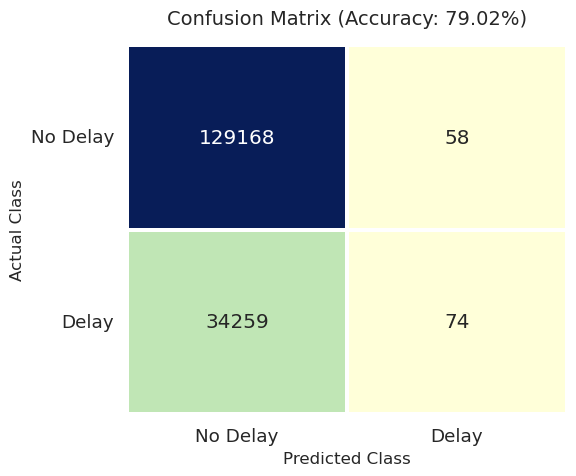

In [72]:
plot_confusion_matrix(test_labels,target_predicted)

Sensitivity or TPR:  0.2155360731657589 %
Specificity or TNR:  99.95511739123705 %
Precision:  56.060606060606055 %
Negative Predictive Value:  79.03712360870603 %
False Positive Rate:  0.04488260876294244 %
False Negative Rate:  99.78446392683425 %
False Discovery Rate:  43.93939393939394 %
Accuracy:  79.01858045109105 %
Validation AUC 0.5008532673220141
Figure(640x480)


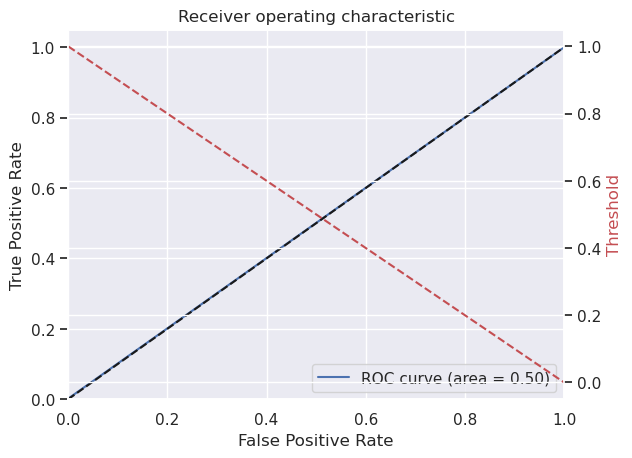

<Figure size 640x480 with 0 Axes>

In [62]:
plot_roc(test_labels, target_predicted)

### Key questions to consider:

1. How does your model's performance on the test set compare to its performance on the training set? What can you deduce from this comparison? 
2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 
3. Given your business situation and goals, which metric (or metrics) is the most important for you to consider? Why?
4. From a business standpoint, is the outcome for the metric (or metrics) that you consider to be the most important sufficient for what you need? If not, what are some things you might change in your next iteration? (This will happen in the feature engineering section, which is next.)

Use the following cells to answer these (and other) questions. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: In your project presentation, write down your answers to these questions -- and other similar questions that you might answer -- in this section. Record the key details and decisions that you made.</span>


**Question**: What can you summarize from the confusion matrix?


In [ ]:
# Enter your answer here

## <span style="color:red"> End of Step 3 </span>

Save the project file to your local computer. Follow these steps:

1. In the file explorer on the left, right-click the notebook that you're working on. 

2. Select **Download**, and save the file locally.  

This action downloads the current notebook to the default download folder on your computer.

# Iteration II

# Step 4: Feature engineering

You have now gone through one iteration of training and evaluating your model. Given that the first outcome that you reached for your model probably wasn't sufficient for solving your business problem, what could you change about your data to possibly improve model performance?

### Key questions to consider:

1. How might the balance of your two main classes (*delay* and *no delay*) impact model performance?
2. Do you have any features that are correlated?
3. At this stage, could you perform any feature-reduction techniques that might have a positive impact on model performance? 
4. Can you think of adding some more data or datasets?
5. After performing some feature engineering, how does the performance of your model compare to the first iteration?

Use the following cells to perform specific feature-engineering techniques that you think could improve your model performance (use the previous questions as a guide). Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: In your project presentation, record your key decisions and the methods that you use in this section. Also include any new performance metrics that you obtain after you evaluate your model again.</span>

Before you start, think about why the precision and recall are around 80 percent, and the accuracy is at 99 percent.

Add more features:

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark them.

The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

# Creative Addition

In [125]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data_orig['Season'] = pd.to_datetime(data_orig['FlightDate']).dt.month.apply(get_season)

In [126]:
data_orig.head(5)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,...,is_holiday,AWND_O,PRCP_O,SNOW_O,TAVG_O,AWND_D,PRCP_D,SNOW_D,TAVG_D,Season
0,2014,3,9,10,3,2014-09-10,UA,DEN,CO,ORD,...,False,47,33,0.0,151.0,71,333,0.0,224.0,Fall
1,2014,3,9,10,3,2014-09-10,UA,IAH,TX,LAX,...,False,31,0,0.0,294.0,28,0,0.0,218.0,Fall
2,2014,3,9,10,3,2014-09-10,UA,DEN,CO,LAX,...,False,47,33,0.0,151.0,28,0,0.0,218.0,Fall
3,2014,3,9,10,3,2014-09-10,UA,DFW,TX,DEN,...,False,70,0,0.0,319.0,47,33,0.0,151.0,Fall
4,2014,3,9,10,3,2014-09-10,UA,ORD,IL,DEN,...,False,71,333,0.0,224.0,47,33,0.0,151.0,Fall


In [127]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = np.isin(data_orig['FlightDate'], holidays)

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather because of rain, heavy winds, or snow lead to airplane delays? You will now check.

In [74]:
!aws s3 cp s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data2/daily-summaries.csv /home/ec2-user/SageMaker/project/data/
#!wget 'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31' -O /home/ec2-user/SageMaker/project/data/daily-summaries.csv

download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data2/daily-summaries.csv to ../project/data/daily-summaries.csv


Import the weather data that was prepared for the airport codes in the dataset. Use the following stations and airports  for the analysis. Create a new column called *airport* that maps the weather station to the airport name.

In [75]:
weather = pd.read_csv('/home/ec2-user/SageMaker/project/data/daily-summaries.csv')
station = ['USW00023174','USW00012960','USW00003017','USW00094846','USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = {s:a for s,a in zip(station, airports)}
weather['airport'] = weather['STATION'].map(station_map)

From the **DATE** column, create another column called *MONTH*.

In [76]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,01


### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the **SNOW** and **SNWD** columns for missing values by using `fillna()`. To check the missing values for all the columns, use the `isna()` function.

In [77]:
weather.SNOW.fillna(0, inplace=True)
weather.SNWD.fillna(0, inplace=True)
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for *TAVG*, *TMAX*, *TMIN*.

**Hint**: To find the rows that are missing, use the `isna()` function. Then, to get the index, use the list on the *idx* variable.

In [78]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = idx[weather.TAVG.isna()] 
TMAX_idx = idx[weather.TMAX.isna()]
TMIN_idx = idx[weather.TMIN.isna()]
TAVG_idx

array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing *TAVG*, *TMAX*, and *TMIN* values with the average value for a particular station or airport. Because consecutive rows of *TAVG_idx* are missing, replacing them with a previous value would not be possible. Instead, replace them with the mean. Use the `groupby` function to aggregate the variables with a mean value.

**Hint:** Group by `MONTH` and `STATION`.

In [82]:
weather_impute = weather.groupby(['MONTH', 'STATION']).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

,MONTH,STATION,TAVG,TMAX,TMIN
0,01,USW00003017,-2.741935,74.000000,-69.858065
1,01,USW00003927,79.529032,143.767742,20.696774


Merge the mean data with the weather data.

In [83]:

weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [84]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset.

In [85]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [86]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It's always a good practice to check for nulls or NAs after joins.

In [87]:
sum(data.isna().any())

0

In [88]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data by using one-hot encoding.

In [89]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [90]:
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data_dummies = data_dummies.replace({True: 1, False: 0})
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

Check the new columns.

In [91]:
data.shape

(1635590, 86)

In [92]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the **is_delay** column to *target* again. Use the same code that you used previously.

In [93]:
data.rename(columns = {'is_delay':'target'}, inplace=True )# Enter your code here

Create the training sets again.

**Hint:** Use the `split_data` function that you defined (and used) earlier.

In [95]:
train, validate, test = split_data(data)
print("Train\n", train['target'].value_counts())
print("Test\n", test['target'].value_counts())
print("Validate\n",validate['target'].value_counts())

Train
 0.0    1033806
1.0     274666
Name: target, dtype: int64
Test
 0.0    129226
1.0     34333
Name: target, dtype: int64
Validate
 0.0    129226
1.0     34333
Name: target, dtype: int64


### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [96]:
# Instantiate the LinearLearner estimator object
classifier_estimator2 = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                               binary_classifier_model_selection_criteria = 'cross_entropy_loss')

### Sample code

```
num_classes = len(pd.unique(train_labels)) 
classifier_estimator2 = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                               binary_classifier_model_selection_criteria = 'cross_entropy_loss')
```

In [98]:
train_records = classifier_estimator2.record_set(train.values[:, 1:].astype(np.float32), train.values[:, 0].astype(np.float32), channel='train')
val_records = classifier_estimator2.record_set(validate.values[:, 1:].astype(np.float32), validate.values[:, 0].astype(np.float32), channel='validation')
test_records = classifier_estimator2.record_set(test.values[:, 1:].astype(np.float32), test.values[:, 0].astype(np.float32), channel='test')

Train your model by using the three datasets that you just created.

In [99]:
classifier_estimator2.fit([train_records,val_records,test_records])

[04/06/25 04:35:59] INFO     Same images used for training and inference. Defaulting to image     ]8;id=930225;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=522339;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=296129;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=461156;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=646809;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=609547;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=656135;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=68910;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name:                                       ]8;id=225456;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=971730;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             linear-learner-2025-04-06-04-35-59-770                                                

2025-04-06 04:36:00 Starting - Starting the training job...
2025-04-06 04:36:15 Starting - Preparing the instances for training...
2025-04-06 04:36:41 Downloading - Downloading input data...
2025-04-06 04:37:26 Downloading - Downloading the training image.........
2025-04-06 04:38:37 Training - Training image download completed. Training in progress...................
2025-04-06 04:42:06 Uploading - Uploading generated training model
2025-04-06 04:42:06 Completed - Training job completed
..Training seconds: 326
Billable seconds: 326


Perform a batch prediction by using the newly trained model.

In [100]:
test_labels, target_predicted = batch_linear_predict(test, classifier_estimator2)

[04/06/25 04:42:21] INFO     Same images used for training and inference. Defaulting to image     ]8;id=956368;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=226696;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=608770;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=5432;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating model with name: linear-learner-2025-04-06-04-42-21-928       ]8;id=320718;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=844620;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/06/25 04:42:22] INFO     Creating transform job with name:                                      ]8;id=723954;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=698683;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3951\3951]8;;\
                             linear-learner-2025-04-06-04-42-22-604                                                

..........................................
...

Plot a confusion matrix.

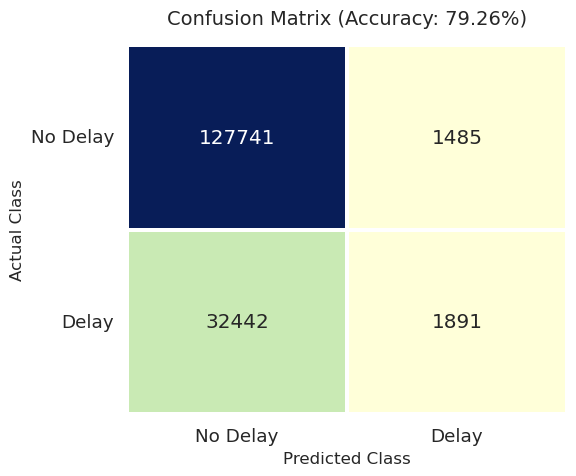

In [101]:
plot_confusion_matrix(test_labels, target_predicted)

Sensitivity or TPR:  5.507820464276352 %
Specificity or TNR:  98.85085044805226 %
Precision:  56.01303317535545 %
Negative Predictive Value:  79.74691446657886 %
False Positive Rate:  1.1491495519477506 %
False Negative Rate:  94.49217953572365 %
False Discovery Rate:  43.986966824644554 %
Accuracy:  79.25702651642527 %
Validation AUC 0.521793354561643
Figure(640x480)


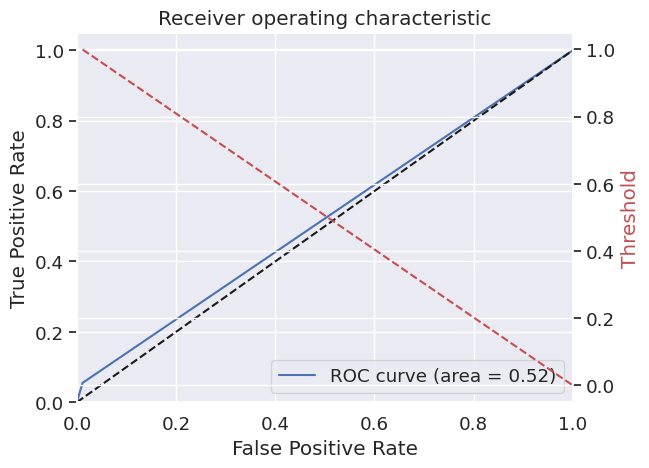

<Figure size 640x480 with 0 Axes>

In [102]:
plot_roc(test_labels, target_predicted)

The linear model shows only a little improvement in performance. Try a tree-based ensemble model, which is called *XGBoost*, with Amazon SageMaker.

### Try the XGBoost model

Perform these steps:  

1. Use the training set variables and save them as CSV files: train.csv, validation.csv and test.csv.
2. Store the bucket name in the variable. The Amazon S3 bucket name is provided to the left of the lab instructions.  
a. `bucket = <LabBucketName>`  
b. `prefix = 'flight-xgb'`  
3. Use the AWS SDK for Python (Boto3) to upload the model to the bucket.    

In [104]:
bucket='sagemaker-us-east-1-058264117601'
prefix='flight-xgb'
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'
whole_file='flight.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

[04/06/25 04:55:23] INFO     Found credentials from IAM Role:                                   ]8;id=711138;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=416009;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Use the `sagemaker.inputs.TrainingInput` function to create a `record_set` for the training and validation datasets.

In [105]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [106]:
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

[04/06/25 04:55:49] INFO     Defaulting to only available Python version: py3                     ]8;id=245186;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=890708;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#610\610]8;;\

                    INFO     Defaulting to only supported image scope: cpu.                       ]8;id=34886;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=385286;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#534\534]8;;\

In [107]:
sess = sagemaker.Session()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type=instance_type,
                                    output_path=s3_output_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit(inputs=data_channels)

[04/06/25 04:56:56] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=720199;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=758527;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=295581;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=655124;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-06-04-56-56-301                                             

2025-04-06 04:56:57 Starting - Starting the training job...
2025-04-06 04:57:12 Starting - Preparing the instances for training...
2025-04-06 04:57:39 Downloading - Downloading input data...
2025-04-06 04:58:14 Downloading - Downloading the training image......
2025-04-06 04:59:05 Training - Training image download completed. Training in progress.........................
2025-04-06 05:03:25 Uploading - Uploading generated training model
2025-04-06 05:03:25 Completed - Training job completed
..Training seconds: 345
Billable seconds: 345


Use the batch transformer for your new model, and evaluate the model on the test dataset.

In [108]:
batch_X = test.iloc[:,1:];
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [109]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

[04/06/25 05:03:58] INFO     Creating model with name: sagemaker-xgboost-2025-04-06-05-03-58-171    ]8;id=854744;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=13852;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating transform job with name:                                      ]8;id=354217;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=892146;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3951\3951]8;;\
                             sagemaker-xgboost-2025-04-06-05-03-58-789                                             

.......................................
...

Get the predicted target and test labels.

In [110]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
test_labels = test.iloc[:,0]

Calculate the predicted values based on the defined threshold.

**Note:** The predicted target will be a score, which must be converted to a binary class.

In [111]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)

test_labels = test.iloc[:,0]

print(target_predicted.head())

     target
0  0.052659
1  0.219373
2  0.449679
3  0.432524
4  0.287322
   target
0       0
1       0
2       0
3       0
4       0


Plot a confusion matrix for your `target_predicted` and `test_labels`.

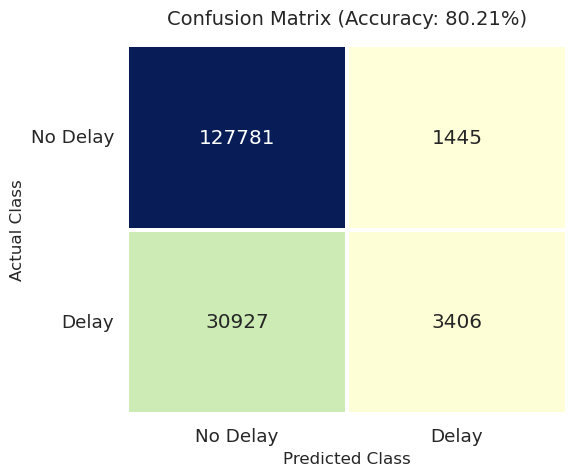

In [112]:
plot_confusion_matrix(test_labels, target_predicted)

### Try different thresholds

Sensitivity or TPR:  9.920484664899659 %
Specificity or TNR:  98.88180397133704 %
Precision:  70.2123273551845 %
Negative Predictive Value:  80.51326965244348 %
False Positive Rate:  1.1181960286629626 %
False Negative Rate:  90.07951533510034 %
False Discovery Rate:  29.7876726448155 %
Accuracy:  80.20775377692453 %
Validation AUC 0.5440114431811834
Figure(640x480)


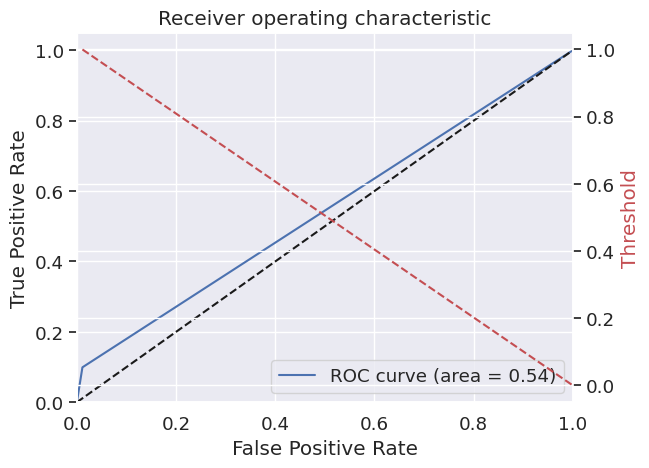

<Figure size 640x480 with 0 Axes>

In [113]:
plot_roc(test_labels, target_predicted)

**Question**: Based on how well the model handled the test set, what can you conclude?

In [ ]:
#Enter your answer here

### Hyperparameter optimization (HPO)

In [114]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

### You can spin up multiple instances to do hyperparameter optimization in parallel

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have a limit set for these instances
                                    instance_type=instance_type, 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 1000, scaling_type='Linear'),
                         'eta': ContinuousParameter(0.1, 0.5, scaling_type='Linear'),
                         'min_child_weight': ContinuousParameter(3, 10, scaling_type='Linear'),
                         'subsample': ContinuousParameter(0.5, 1),
                         'num_round': IntegerParameter(10,150)}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget and available time.
                            max_parallel_jobs=1)

In [115]:
tuner.fit(inputs=data_channels)
tuner.wait()

[04/06/25 05:17:15] WARNING  No finished training job found associated with this estimator.       ]8;id=240533;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=44372;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=477625;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=697962;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=519023;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=358472;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\
                             sagemaker-xgboost-250406-0517                                                         

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
!


<i class="fas fa-exclamation-triangle" style="color:red"></i> Wait until the training job is finished. It might take 25-30 minutes.

**To monitor hyperparameter optimization jobs:**  

1. In the AWS Management Console, on the **Services** menu, choose **Amazon SageMaker**.  
2. Choose **Training > Hyperparameter tuning jobs**.
3. You can check the status of each hyperparameter tuning job, its objective metric value, and its logs.  

Check that the job completed successfully.

In [116]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

The hyperparameter tuning job will have a model that worked the best. You can get the information about that model from the tuning job.

In [117]:
sage_client = boto3.Session().client('sagemaker')
tuning_job_name = tuner.latest_tuning_job.job_name
print(f'tuning job name:{tuning_job_name}')
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
best_training_job = tuning_job_result['BestTrainingJob']
best_training_job_name = best_training_job['TrainingJobName']
print(f"best training job: {best_training_job_name}")

best_estimator = tuner.best_estimator()

tuner_df = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()
tuner_df.head()

[04/06/25 06:06:43] INFO     Found credentials from IAM Role:                                   ]8;id=120219;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=26400;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

tuning job name:sagemaker-xgboost-250406-0517
best training job: sagemaker-xgboost-250406-0517-009-affc0152

2025-04-06 05:58:27 Starting - Found matching resource for reuse
2025-04-06 05:58:27 Downloading - Downloading the training image
2025-04-06 05:58:27 Training - Training image download completed. Training in progress.
2025-04-06 05:58:27 Uploading - Uploading generated training model
2025-04-06 05:58:27 Completed - Resource reused by training job: sagemaker-xgboost-250406-0517-010-6fded35c


,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,30.776656,0.462859,7.743142,36.0,0.513018,sagemaker-xgboost-250406-0517-010-6fded35c,Completed,0.72957,2025-04-06 05:58:30+00:00,2025-04-06 06:00:59+00:00,149.0
1,26.839969,0.237453,4.482515,104.0,0.751361,sagemaker-xgboost-250406-0517-009-affc0152,Completed,0.73942,2025-04-06 05:52:04+00:00,2025-04-06 05:57:29+00:00,325.0
2,325.979799,0.259279,7.860463,123.0,0.776748,sagemaker-xgboost-250406-0517-008-e50ae693,Completed,0.72634,2025-04-06 05:44:26+00:00,2025-04-06 05:50:56+00:00,390.0
3,515.951723,0.438011,3.158364,104.0,0.744704,sagemaker-xgboost-250406-0517-007-dcf160d1,Completed,0.72098,2025-04-06 05:38:58+00:00,2025-04-06 05:43:53+00:00,295.0
4,469.385209,0.313702,9.945242,38.0,0.892781,sagemaker-xgboost-250406-0517-006-95014a84,Completed,0.71601,2025-04-06 05:36:03+00:00,2025-04-06 05:38:27+00:00,144.0


Use the estimator `best_estimator` and train it by using the data. 

**Tip:** See the previous XGBoost estimator fit function.

In [118]:
best_estimator.fit(inputs=data_channels)

[04/06/25 06:07:00] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=418670;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=612678;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=679684;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=182432;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-06-06-07-00-521                                             

2025-04-06 06:07:01 Starting - Starting the training job...
2025-04-06 06:07:16 Starting - Preparing the instances for training...
2025-04-06 06:07:42 Downloading - Downloading input data...
2025-04-06 06:08:17 Downloading - Downloading the training image......
2025-04-06 06:09:08 Training - Training image download completed. Training in progress.....................................
2025-04-06 06:15:18 Uploading - Uploading generated training model
2025-04-06 06:15:18 Completed - Training job completed
..Training seconds: 456
Billable seconds: 456


Use the batch transformer for your new model, and evaluate the model on the test dataset.

In [119]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_estimator.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

[04/06/25 06:15:49] INFO     Creating model with name: sagemaker-xgboost-2025-04-06-06-15-49-367    ]8;id=643145;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=944106;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating transform job with name:                                      ]8;id=942561;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=375467;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3951\3951]8;;\
                             sagemaker-xgboost-2025-04-06-06-15-49-982                                             

....................................
...

In [120]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
test_labels = test.iloc[:,0]

Get the predicted target and test labels.

In [121]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)

test_labels = test.iloc[:,0]

print(target_predicted.head())

     target
0  0.052928
1  0.205420
2  0.497368
3  0.442814
4  0.310828
   target
0       0
1       0
2       0
3       0
4       0


Plot a confusion matrix for your `target_predicted` and `test_labels`.

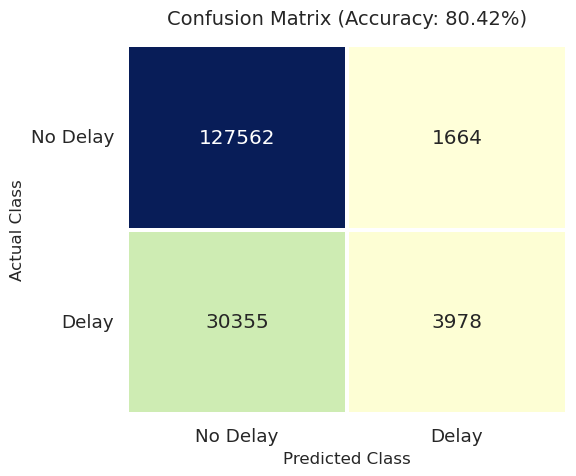

In [122]:
plot_confusion_matrix(test_labels, target_predicted)

**Question**: Try different hyperparameters and hyperparameter ranges. Do these changes improve the model?

Sensitivity or TPR:  11.586520257478227 %
Specificity or TNR:  98.71233343135283 %
Precision:  70.50691244239631 %
Negative Predictive Value:  80.77787698601165 %
False Positive Rate:  1.2876665686471762 %
False Negative Rate:  88.41347974252177 %
False Discovery Rate:  29.493087557603687 %
Accuracy:  80.42357803606038 %
Validation AUC 0.5514942684441553
Figure(640x480)


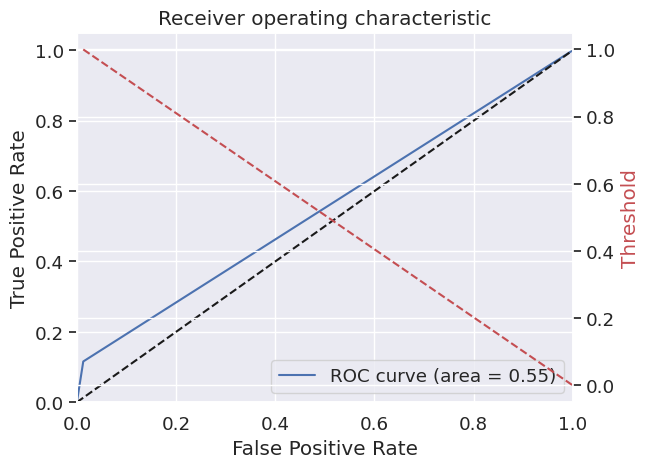

<Figure size 640x480 with 0 Axes>

In [123]:
plot_roc(test_labels, target_predicted)

## Conclusion

You have now iterated through training and evaluating your model at least a couple of times. It's time to wrap up this project and reflect on:

- What you learned 
- What types of steps you might take moving forward (assuming that you had more time)

Use the following cell to answer some of these questions and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. How much did your model improve as you made changes to your dataset, features, and hyperparameters? What types of techniques did you employ throughout this project, and which yielded the greatest improvements in your model?
3. What were some of the biggest challenges that you encountered throughout this project?
4. Do you have any unanswered questions about aspects of the pipeline that didn't make sense to you?
5. What were the three most important things that you learned about machine learning while working on this project?

#### <span style="color: blue;">Project presentation: Make sure that you also summarize your answers to these questions in your project presentation. Combine all your notes for your project presentation and prepare to present your findings to the class.</span>

1. The model partially meets the business goals since it is 80.42% accurate. I would ideally expect the model to be more accurate atleast 85%. If I had more time, I would try to explore additional features or refine existing ones to better capture the patterns in the data. I would also try to identify further optimization techniques for hyperparameter tuning. 
2. The model was initially 79.02% accurate which increased to 79.21% after feature engineering. On hyperparameter tuning, the accuracy further increased to 80.42%. There was gradual increase in the accuracy of the model throughtout from adding features, to XGBoost to hyperparameter tuning. Using XGBoost definetely yeilded better results than linear model.
3. Identifying the most relevant features and creating new ones(creative addition) that added predictive value required significant experimentation and domain knowledge.
4. Could the preprocessing and feature engineering steps have been streamlined further? For instance, were there redundant steps that could have been combined or eliminated?
5. I learnt that creating meaningful features, such as the DayOfWeek feature from the FlightDate column, can significantly impact model performance. I also learnt that quality of the data that we pick is also significantly important. Removing noise is essential in how our prediction works. Finally major lesson I learnt is that iteration is the key in machine learning.